In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [2]:
import tensorflow as tf

In [3]:
import sklearn.preprocessing

In [4]:
import wispy.callbacks

In [5]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [6]:
import pugna.activations
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [185]:
def load_data(name, take_first=None, indicies=None):
    times = np.load("training_data/times.npy")
    X = np.load("training_data/coords.npy").T
    X_val = np.load("validation_data/coords.npy").T
    
    y = np.load(f"training_data/{name}.npy")
    y_val = np.load(f"validation_data/{name}.npy")
    
    if indicies is not None:
#         mask = times >= -10
        mask = times >= times[0]
        return times[mask], X[indicies], y[indicies][:,mask], X_val[indicies], y_val[indicies][:,mask]
    
    elif take_first:
#         take_first = len(X)+1
#         mask = times >= -10
        mask = times >= times[0]
        return times[mask], X[:take_first], y[:take_first,mask], X_val[:take_first], y_val[:take_first,mask]

    else:
        return times, X[:take_first], y[:take_first], X_val[:take_first], y_val[:take_first]

In [196]:
# times, X, y, X_val, y_val = load_data('beta', take_first=4)
# times, X, y, X_val, y_val = load_data('beta', take_first=5)
# times, X, y, X_val, y_val = load_data('beta', indicies=[0,3,4,7,8])
times, X, y, X_val, y_val = load_data('beta', indicies=[0,3,1])
# times, X, y, X_val, y_val = load_data('beta')

In [197]:
# scaler = sklearn.preprocessing.Normalizer()
# y = scaler.fit_transform(y)
# y_val = scaler.transform(y_val)

In [198]:
# y -= y[:,0][:,np.newaxis]
# y_val -= y_val[:,0][:,np.newaxis]

In [199]:
times.shape

(1219,)

In [200]:
X.shape

(3, 7)

In [201]:
y.shape

(3, 1219)

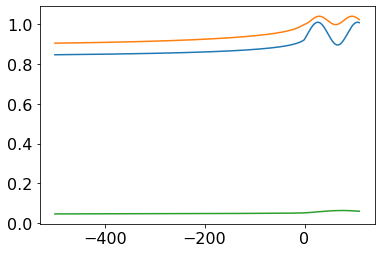

In [202]:
plt.figure()
for yy in y:
    plt.plot(times, yy)

In [203]:
def build_model(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        
#     dense_skip = tf.keras.layers.Dense(units, activation=activation)(input_layer)
#     x = tf.keras.layers.add([dense_skip, x])
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [204]:
X.shape

(3, 7)

In [205]:
y.shape

(3, 1219)

In [227]:
%%time
model_1_params = dict(
    input_shape=X.shape[1],
    output_shape=y.shape[1],
    units=2048,
    activation='s2relu',
    n_hidden_layers=3
)
model_1 = build_model(**model_1_params)
model_1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')


callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100, min_lr=1e-6),
    wispy.callbacks.ThresholdCallback(1e-9)
]
history_1 = model_1.fit(X, y, epochs=1000, batch_size=64, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

CPU times: user 3min 18s, sys: 12 s, total: 3min 30s
Wall time: 1min 5s


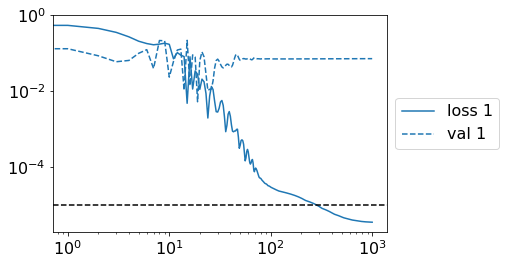

In [228]:
plt.figure()
plt.plot(history_1.history['loss'], label='loss 1', c='C0')
plt.plot(history_1.history['val_loss'], label='val 1', c='C0', ls='--')

plt.axhline(1e-05, c='k', ls='--')

plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [229]:
plt.figure()
plt.plot(history_1.history['lr'], label='lr', c='C0')

plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

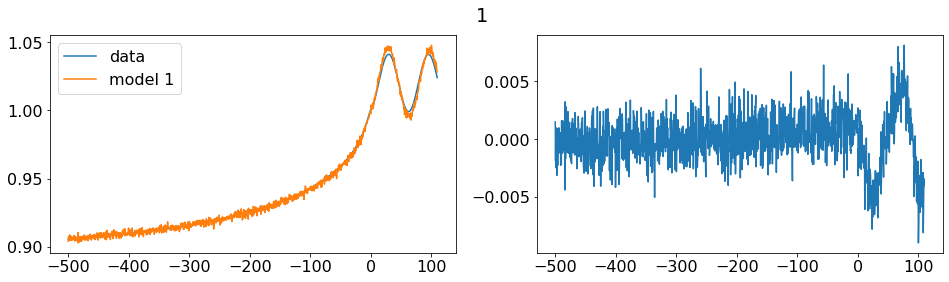

In [230]:
for index in range(X.shape[0]):
    yhat1 = model_1.predict(X[index].reshape(1,-1))[0]
    plt.figure(figsize=(16,4))
    plt.subplot(1, 2, 1)
    plt.plot(times, y[index], label='data')
    plt.plot(times, yhat1, label='model 1')
    plt.legend()
    # plt.xlim(-100, 100)
    plt.subplot(1, 2, 2)
    plt.plot(times, y[index]-yhat1)
    plt.suptitle(index)
    plt.show()
    plt.close